In [1]:
!pip install gensim==4.3.2


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pickle
import pandas as pd
import nltk
import gensim

import numpy as np

import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AffinityPropagation
from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer

# Visualization & topic modelling
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install --user plotly
import plotly
import plotly.express as px

# utility modules
from ast import literal_eval

In [3]:
word_level_df = pd.read_csv('/work/GitHub_ML_Deepnote/Machine Learning/2. Cleaning & Pre-processing/word_level_df.csv', encoding='utf-8', index_col=0)
sentence_level_df = pd.read_csv('/work/GitHub_ML_Deepnote/Machine Learning/2. Cleaning & Pre-processing/sentence_level_df.csv',  encoding='utf-8', index_col = 0)

In [4]:
# Extract lemmas from the 'lemmas' column in word_level_df
corpus_words = [literal_eval(lemmas) for lemmas in word_level_df['lemmas'].values]

# Save corpus_words as a pickle file
with open('/work/GitHub_ML_Deepnote/Machine Learning/3. Word2vec /corpus_words.pkl', 'wb') as file:
    pickle.dump(corpus_words, file)

In [5]:
corpus_model = gensim.models.Word2Vec(corpus_words, min_count= 20, vector_size = 300)

In [6]:
corpus_model.wv['fear']

array([ 8.77381265e-02,  2.59313375e-01,  3.72180603e-02,  2.14233786e-01,
        1.48920726e-03, -2.83880085e-01,  1.79718658e-01,  4.31177765e-01,
       -3.18431892e-02,  3.16052847e-02, -2.97556575e-02, -1.45918638e-01,
        1.03141375e-01,  5.84003590e-02, -1.80113584e-01, -2.03409344e-01,
        1.50771320e-01, -2.58907918e-02,  4.68977094e-02, -7.94615746e-02,
       -5.20852879e-02, -7.39674270e-02,  9.56141502e-02,  1.71934795e-02,
        1.21984318e-01, -5.58360331e-02, -2.21563444e-01, -3.82067300e-02,
       -1.51069701e-01, -1.48716182e-01,  1.34576866e-02, -2.01409891e-01,
       -2.59098522e-02, -9.15179402e-03, -1.23493457e-02,  6.08219542e-02,
        1.51263857e-02, -1.15171328e-01,  2.60346886e-02, -5.54601923e-02,
       -1.22155331e-01,  2.53089610e-02, -8.17562193e-02, -1.67354867e-01,
        9.20666978e-02,  2.14769676e-01,  2.85041681e-03,  6.62772264e-03,
       -1.57699920e-02,  7.56543353e-02,  4.55410294e-02, -3.38794924e-02,
       -1.17538661e-01,  

In [7]:
#Creating a dataframe out of the corpus to train the model and it's relative word vectors.
corpus_vocab = corpus_model.wv.index_to_key
corpus_vectors = [corpus_model.wv[i] for i in corpus_vocab]
corpus_df = pd.DataFrame(corpus_vectors)

#Needed for principle component analysis 
corpus_df.columns = [str(i) for i in corpus_df.columns]


In [8]:
# Concatinating - reducing the dimensionality of the data into 3 components so we can plot it & visualise it. 

pca = PCA(n_components = 3)
comps_1 = pca.fit_transform(corpus_vectors)
pc_df_1 = pd.DataFrame(data = comps_1, columns = ['Principal Component '+str(i) for i in range(1, comps_1.shape[1]+1)])
corpus_df = pd.concat([corpus_df, pc_df_1], axis = 1)
corpus_df.index = corpus_vocab

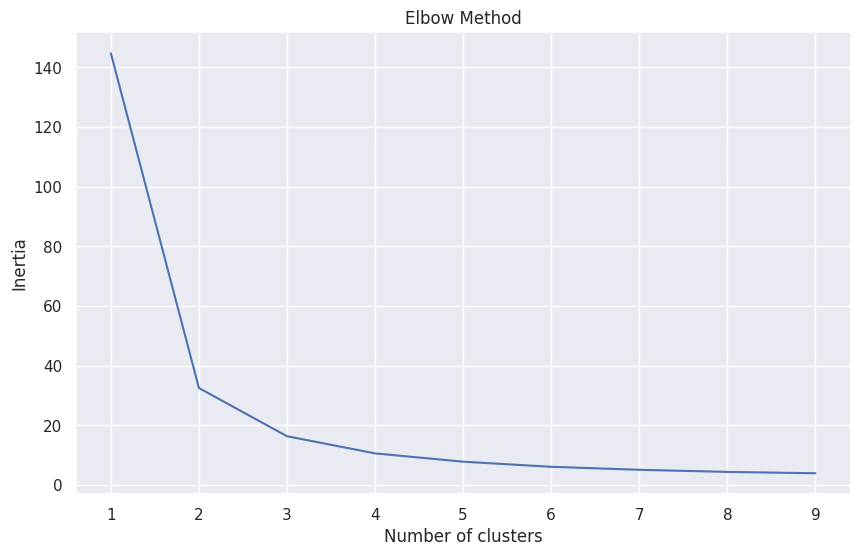

In [9]:
#Elbow method to identify number of clusters - this method indicates 2 as a good number.

#range being tested
inertia = []
K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(corpus_vectors)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6))
# sns.lineplot(x=K, y=inertia, marker='o')
plt.plot(K,inertia)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show() 

For n_clusters = 2 The average silhouette_score is : 0.6560381472567406
For n_clusters = 3 The average silhouette_score is : 0.586370100900528
For n_clusters = 4 The average silhouette_score is : 0.5364329455985152
For n_clusters = 5 The average silhouette_score is : 0.49519487937941425
For n_clusters = 6 The average silhouette_score is : 0.4557564159441115
For n_clusters = 7 The average silhouette_score is : 0.4398729964133744
For n_clusters = 8 The average silhouette_score is : 0.41850685513058317
For n_clusters = 9 The average silhouette_score is : 0.40085286670734266


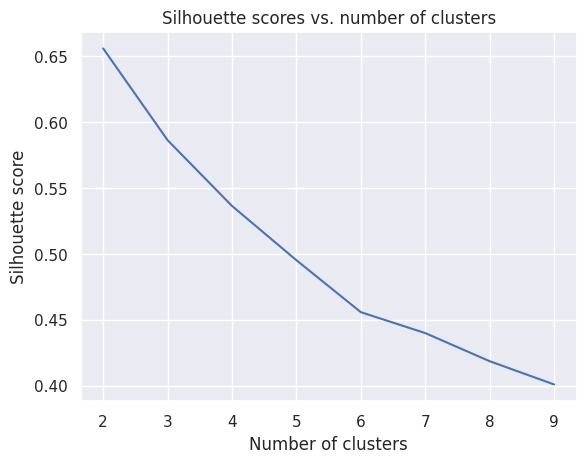

In [10]:
#Silhoutte method to identify optimal amount of clusters. This method is indicating 5.

#range of clusters to test
range_n_clusters = range(2, 10)

# Converting dataframe to numpy array for clustering
X = np.array(corpus_df)

# Initialising list to store silhouette scores for each number of clusters
silhouette_scores = []

# Iterating over set range of clusters and calculating silhouette score
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init= 10)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

# Plotting silhouette scores vs. number of clusters. A higher average silhouette score indicates better-defined clusters.
plt.plot(range_n_clusters, silhouette_scores)
plt.title("Silhouette scores vs. number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

In [18]:
# Clustering our data to see what groups together

kmeans = KMeans(n_clusters=2, random_state=0, n_init= 10 ).fit(corpus_df)

#Adding relevant values to our dataframe
corpus_df['clusters_knn'] = [str(i) for i in kmeans.labels_]

In [19]:
#Dimension reduction visualised and categorised into clusters

fig = px.scatter_3d(
    corpus_df, 
    x='Principal Component 1', y='Principal Component 2', z='Principal Component 3',
    color='clusters_knn',
    hover_data = [corpus_df.index]
    )

fig.update_traces(marker=dict(size = 5, line=dict(width=2,color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.show()

pd.set_option('display.max_rows', None)

In [13]:
# Save the 3D scatter plot as an HTML file
fig.write_html('/work/GitHub_ML_Deepnote/Machine Learning/3. Word2vec /scatter_plot_3d.html')

### Using model (will be better once more data is added)

In [22]:
corpus_model.wv.most_similar(['future'])


[('ever', 0.9996487498283386),
 ('cause', 0.9996299743652344),
 ('utopia', 0.9996275305747986),
 ('compare', 0.9996196627616882),
 ('basically', 0.9996193647384644),
 ('situation', 0.9996170401573181),
 ('today', 0.9996145963668823),
 ('support', 0.9996138215065002),
 ('rather', 0.9996119737625122),
 ('possibly', 0.9996112585067749)]

In [15]:
corpus_model.wv.similarity("fear", "future")


0.9992228

In [16]:
corpus_model.wv.similarity("asi", "future")


0.9995055

In [17]:
corpus_model.wv.doesnt_match(['crisis',"fear", "asi", "good", "solution"])


'fear'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f64215d6-debc-46bd-b273-63565459a66d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>